In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
np.random.seed(0)

In [223]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

In [224]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature Selection

In [226]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [227]:
target = 'Survived'
n_features = 3
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked','IsAlone', 'Title', 'SibSp', 'Parch']

In [228]:
correlation = {}
for i in features:
    if i in df.columns:
        correlation[i] = abs(df[i].corr(df[target]))

In [229]:
sorted_ = sorted(correlation.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_[:n_features]]

In [230]:
for i, (feat, corr) in enumerate(sorted_[:n_features], 1):
    print(f"{i}. {feat}: {corr:.2f}")

1. Sex: 0.54
2. Pclass: 0.34
3. Fare: 0.26


In [231]:
xx= df[top_features].values
y = df['Survived'].values.reshape(-1, 1)

In [232]:
# Min-Max Scaler
x = (xx - xx.min(axis=0)) / (xx.max(axis=0) - xx.min(axis=0) + 1e-8)

In [233]:
# Trian Test Split
test_size = 0.2
class0 = np.where(y.flatten() == 0)[0]
class1 = np.where(y.flatten() == 1)[0]
np.random.shuffle(class0)
np.random.shuffle(class1)

In [234]:
split0 = int(len(class0) * 0.80) 
split1 = int(len(class1) * 0.80)
train_indices = np.concatenate([class0[:split0] , class1[:split1]])
val_indices = np.concatenate([class0[split0:] , class1[split1:]])

In [235]:
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

In [236]:
x_train = x[train_indices]
x_val = x[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

In [237]:
print(len(x_train) , len(x_val))

712 179


# Trianing Neural Networks 

In [239]:
w1 = np.random.randn(3, 2) * np.sqrt(2. / 3)
b1 = np.zeros((1, 2))
w2 = np.random.randn(2, 2) * np.sqrt(2. / 2)
b2 = np.zeros((1, 2))
w3 = np.random.randn(2, 1) * np.sqrt(1. / 2)
b3 = np.zeros((1, 1))

In [240]:
losses = []
accuracies = []

In [241]:
for epoch in range(1500):
    z1 = np.dot(x_train, w1) + b1
    h1 = np.where(z1 > 0, z1, z1 * 0.01) # Leaky reLU
    z2 = np.dot(h1, w2) + b2
    h2 = np.where(z2 > 0, z2, z2 * 0.01) # Leaky reLU
    z3 = np.dot(h2, w3) + b3
    output = 1 / (1 + np.exp(-np.clip(z3, -500, 500))) # Sigmoid

    m = x_train.shape[0]

    delta_output = output - y_train 
    # Hidden Layer 2 error
    delta_h2 = np.dot(delta_output, w3.T) * np.where(z2 > 0, 1, 0.01) # Leaky ReLU derivative
    
    # Hidden Layer 1 error
    delta_h1 = np.dot(delta_h2, w2.T) * np.where(z1 > 0, 1, 0.01) # Leaky ReLU derivative

    lr= 0.1

    w3 -= lr * np.dot(h2.T, delta_output) / m
    b3 -= lr * np.sum(delta_output, axis=0, keepdims=True) / m
    w2 -= lr * np.dot(h1.T, delta_h2) / m
    b2 -= lr * np.sum(delta_h2, axis=0, keepdims=True) / m
    w1 -= lr * np.dot(x_train.T, delta_h1) / m
    b1 -= lr * np.sum(delta_h1, axis=0, keepdims=True) / m

    if epoch % 100 == 0 or epoch == 4999:
        # Training loss
        epsilon = 1e-15
        clipped_output = np.clip(output, epsilon, 1 - epsilon)
        train_loss = -np.mean(y_train * np.log(clipped_output) + (1 - y_train) * np.log(1 - clipped_output))
        
        # Training accuracy
        train_predictions = (output >= 0.5).astype(int)
        train_acc = np.mean(train_predictions == y_train)
        
        # Validation forward pass
        val_z1 = np.dot(x_val, w1) + b1
        val_h1 = np.where(val_z1 > 0, val_z1, val_z1 * 0.01)
        val_z2 = np.dot(val_h1, w2) + b2
        val_h2 = np.where(val_z2 > 0, val_z2, val_z2 * 0.01)
        val_z3 = np.dot(val_h2, w3) + b3
        val_output = 1 / (1 + np.exp(-np.clip(val_z3, -500, 500)))

        # Validation loss
        clipped_val_output = np.clip(val_output, epsilon, 1 - epsilon)
        val_loss = -np.mean(y_val * np.log(clipped_val_output) + (1 - y_val) * np.log(1 - clipped_val_output))
        
        # Validation accuracy
        val_predictions = (val_output >= 0.5).astype(int)
        val_acc = np.mean(val_predictions == y_val)
        
        losses.append((train_loss, val_loss))
        accuracies.append((train_acc, val_acc))
        
        print(f"Epoch {epoch:4d} | Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        
        




Epoch    0 | Train Loss: 0.6001 | Train Acc: 0.6110 | Val Loss: 0.6095 | Val Acc: 0.6145
Epoch  100 | Train Loss: 0.5233 | Train Acc: 0.7542 | Val Loss: 0.5532 | Val Acc: 0.7374
Epoch  200 | Train Loss: 0.4935 | Train Acc: 0.7612 | Val Loss: 0.5269 | Val Acc: 0.7430
Epoch  300 | Train Loss: 0.4783 | Train Acc: 0.7837 | Val Loss: 0.5124 | Val Acc: 0.7709
Epoch  400 | Train Loss: 0.4711 | Train Acc: 0.7851 | Val Loss: 0.5052 | Val Acc: 0.7709
Epoch  500 | Train Loss: 0.4675 | Train Acc: 0.7893 | Val Loss: 0.5013 | Val Acc: 0.7709
Epoch  600 | Train Loss: 0.4650 | Train Acc: 0.7907 | Val Loss: 0.4989 | Val Acc: 0.7709
Epoch  700 | Train Loss: 0.4632 | Train Acc: 0.7921 | Val Loss: 0.4971 | Val Acc: 0.7765
Epoch  800 | Train Loss: 0.4617 | Train Acc: 0.7921 | Val Loss: 0.4958 | Val Acc: 0.7765
Epoch  900 | Train Loss: 0.4605 | Train Acc: 0.7921 | Val Loss: 0.4947 | Val Acc: 0.7765
Epoch 1000 | Train Loss: 0.4595 | Train Acc: 0.7921 | Val Loss: 0.4939 | Val Acc: 0.7765
Epoch 1100 | Train Lo

In [242]:
print(f"\nFinal Training Accuracy:   {train_acc_final:.4f} ") 
print(f"Final Validation Accuracy: {val_acc_final:.4f} ")


Final Training Accuracy:   0.7921 
Final Validation Accuracy: 0.7765 


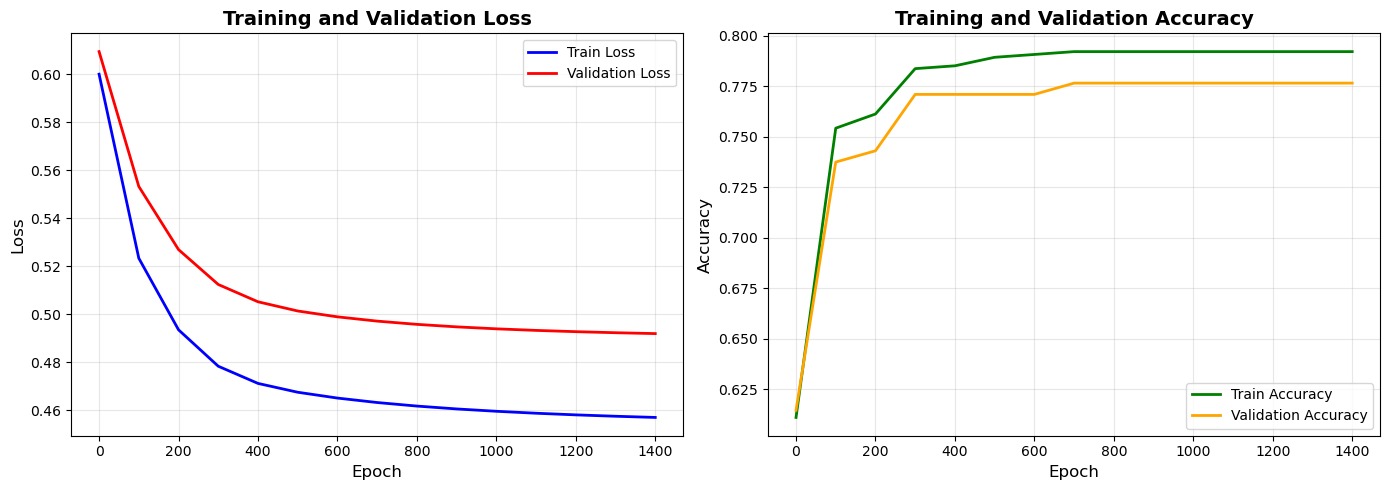

In [243]:
# --- Plot training history ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_losses = [l[0] for l in losses]
val_losses = [l[1] for l in losses]
epochs_recorded = range(0, len(train_losses) * 100, 100)

axes[0].plot(epochs_recorded, train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(epochs_recorded, val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

train_accs = [a[0] for a in accuracies]
val_accs = [a[1] for a in accuracies]

axes[1].plot(epochs_recorded, train_accs, label='Train Accuracy', color='green', linewidth=2)
axes[1].plot(epochs_recorded, val_accs, label='Validation Accuracy', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

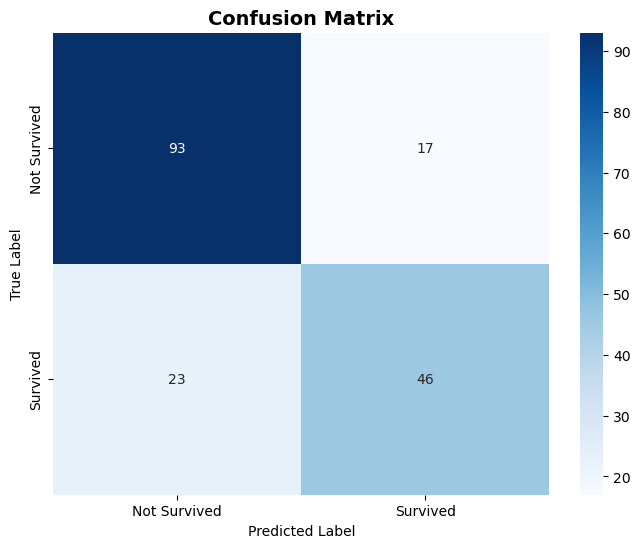


Confusion Matrix:
True Negatives:  93
False Positives: 17
False Negatives: 23
True Positives:  46


In [244]:
y_true_flat = y_val.flatten()
y_pred_flat = val_pred.flatten()
tp = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
tn = np.sum((y_true_flat == 0) & (y_pred_flat == 0))
fp = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
fn = np.sum((y_true_flat == 1) & (y_pred_flat == 0))
cm = np.array([[tn, fp], [fn, tp]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

print("\nConfusion Matrix:")
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")
